#This notebook demonstrates how to implement RNNs in theano.

First, we import some dependencies:

In [83]:
%matplotlib inline
from synthetic import mackey_glass
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import numpy

floatX = theano.config.floatX

We now define a class that uses `scan` to initialize an RNN and apply it to a sequence of data vectors. The constructor initializes the shared variables after which the instance can be called on a symbolic variable to construct an RNN graph. Note that this class only handles the computation of the hidden layer activations. We'll define a set of output weights later.

In [84]:
class SimpleRNN(object):
    def __init__(self, input_dim, recurrent_dim):
        w_xh = numpy.random.normal(0, .01, (input_dim, recurrent_dim))
        w_hh = numpy.random.normal(0, .01, (recurrent_dim, recurrent_dim))
        self.w_xh = theano.shared(numpy.asarray(w_xh, dtype=floatX), name='w_xh')
        self.w_hh = theano.shared(numpy.asarray(w_hh, dtype=floatX), name='w_hh')
        self.b_h = theano.shared(numpy.zeros((recurrent_dim,), dtype=floatX), name='b_h')
        self.parameters = [self.w_xh, self.w_hh, self.b_h]
        
    def __call__(self, x):
        x_w_xh = T.dot(x, self.w_xh) + self.b_h
        
        def step(input_t, previous, w_hh):
            return T.tanh(T.dot(previous, w_hh) + input_t)
        
        result, updates = theano.scan(step,
                                      sequences=[x_w_xh],
                                      non_sequences=[self.w_hh],
                                      outputs_info=[T.zeros_like(self.b_h)])
        return result

For visualization purposes and to keep the optimization time managable, we will train the RNN on a short synthetic chaotic time series. Let's first have a look at the data:

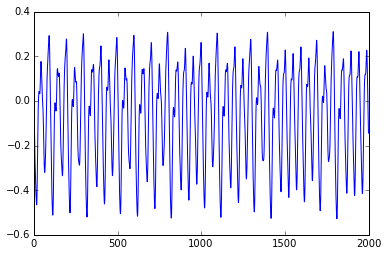

In [85]:
data = numpy.asarray(mackey_glass(2000)[0], dtype=floatX)
plt.plot(data)
plt.show()


To train an RNN model on this sequences, we need to generate a theano graph that computes the cost and its gradient. In this case, the task will be to predict the next time step and the error objective will be the mean squared error (MSE). We also need to define shared variables for the output weights.

In [86]:
w_ho_np = numpy.random.normal(0, .01, (10, 1))
w_ho = theano.shared(numpy.asarray(w_ho_np, dtype=floatX), name='w_ho')
b_o= theano.shared(numpy.zeros((1,), dtype=floatX), name='b_o')

x = T.matrix('x')
my_rnn = SimpleRNN(1, 10)
hidden = my_rnn(x)
prediction = T.dot(hidden, w_ho) + b_o
cost = T.mean((prediction[:-1] - x[1:])**2)
parameters = my_rnn.parameters + [w_ho, b_o]

gradient = T.grad(cost, wrt=parameters)

We now compile the function that wil update the parameters of the model using gradient descent. 

In [87]:
lr = .1
updates = [(par, par - lr * gra) for par, gra in zip(parameters, gradient)] 
update_model = theano.function([x], cost, updates=updates)

We can now train the network by supplying this function with our data and calling it repeatedly.

In [88]:
for i in range(1000):
    mse = update_model(data)
    if i % 100 == 0:
        print mse

0.0510615520179
0.0463637001812
0.0443199723959
0.0328347720206
0.00459064496681
0.0020908319857
0.00192300637718
0.00178743421566
0.00167483545374
0.00157952797599


Since we're only looking at a very small toy problem here, the model probably already memorized the train data quite well. Let's find out by plotting the predictions of the network:

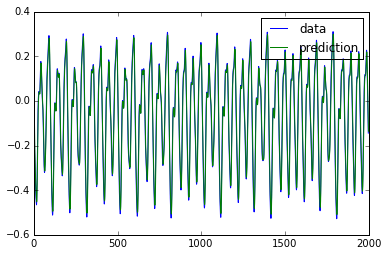

In [92]:
predict = theano.function([x], prediction)
prediction_np = predict(data)
plt.plot(data[1:], label='data')
plt.plot(prediction_np, label='prediction')
plt.legend()
plt.show()

# Exercises
## Exercise 1 - Generating sequences
Predicting a single step ahead is a relatively easy task. It would be more intresting to see if the network actually learned how to generate multiple time steps such that it can continue the sequence.
Write code that generates the next 1000 examples after processing the train sequence.